# Multi-Modal RAG

There are 3 ways to create multi-modal-rag
1. Use a multi-modal embedding model like CLIP or imagebind to create embedding  of images and text. REtrieve bith using similarity search and pass the documents toa multi-modal LLM
2. Use a multi-modal model to create summarues of images. Retrieve the summarues from vector storage and pass them to an llm for Q&A
3. Use a multi-modal LLM to fer description of images. Embed the text description using any embedding model of choice and store original document in doc store Retrieve summarues with a reference to the original image and text chunks. Pass the original document to a multi-modal LLM for answer generation


![image](https://av-eks-lekhak.s3.amazonaws.com/media/__sized__/article_images/mm-rag-thumbnail_webp-600x300.webp)

In [1]:
# !sudo apt install tesseract-ocr
# !sudo apt-get install poppler-utils

In [2]:
# !pip install "unstructured[all-docs]" 
# !pip install  unstructured

In [3]:
# !pip install langchain==0.1.0 langchain-community==0.0.12 langchain-core==0.1.10 \
# langchain-experimental==0.0.49 \
# langchain-google-genai==0.0.6

In [4]:
from unstructured.partition.pdf import partition_pdf

img_path = "./images"
pdf_elemnts = partition_pdf(
    "./Document/mistral.pdf",
    chunking_strategy="by_title",
    extract_images_in_pdf=True,
    max_characters=3000,
    new_after_n_chars=2800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=img_path,
)

**Saperate text and tables**

In [5]:
from dotenv import load_dotenv
_ = load_dotenv()

In [6]:
# Categorize elements by type
def categorize_elements(raw_pdf_elements):
    """
    Categorize extracted elements from a PDF into tables and texts.
    raw_pdf_elements: List of unstructured.documents.elements
    """
    tables = []
    texts = []
    for element in raw_pdf_elements:
        if "unstructured.documents.elements.Table" in str(type(element)):
            tables.append(str(element))
        elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
            texts.append(str(element))
    return texts, tables


texts, tables = categorize_elements(pdf_elemnts)

In [7]:
from langchain.chat_models import ChatVertexAI
from langchain.llms import VertexAI
from langchain.prompts import PromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain_core.messages import AIMessage
from langchain_core.runnables import RunnableLambda
import pathlib
import textwrap
from langchain_google_genai import GoogleGenerativeAI
from langchain_google_genai import ChatGoogleGenerativeAI
import os

api_key = os.getenv("GOOGLE_API_KEY")
llm = ChatGoogleGenerativeAI(model="gemini-pro", google_api_key=api_key)


# Generate summaries of text elements
def generate_text_summaries(texts, tables, summarize_texts=False):
    """
    Summarize text elements
    texts: List of str
    tables: List of str
    summarize_texts: Bool to summarize texts
    """

    # Prompt
    prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well-optimized for retrieval. Table \
    or text: {element} """
    prompt = PromptTemplate.from_template(prompt_text)
    empty_response = RunnableLambda(
        lambda x: AIMessage(content="Error processing document")
    )
    # Text summary chain
    model = llm.with_fallbacks([empty_response])
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    # Initialize empty summaries
    text_summaries = []
    table_summaries = []

    # Apply to text if texts are provided and summarization is requested
    if texts and summarize_texts:
        text_summaries = summarize_chain.batch(texts, {"max_concurrency": 1})
    elif texts:
        text_summaries = texts

    # Apply to tables if tables are provided
    if tables:
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 1})

    return text_summaries, table_summaries


# Get text, table summaries
text_summaries2, table_summaries = generate_text_summaries(
    texts[9:], tables, summarize_texts=True
)

## Image Summaries

In [8]:
import base64
import os

from langchain_core.messages import HumanMessage


def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64, prompt):
    """Make image summary"""
    model =  ChatGoogleGenerativeAI(model="gemini-pro-vision", google_api_key=api_key)

    msg = model(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            print(f"Summarizing image: {img_file}")
            image_summaries.append(image_summarize(base64_image, prompt))
            print(f"Summarized image: {img_file}")

    return img_base64_list, image_summaries


fpath = "./"
# Image summaries
img_base64_list, image_summaries = generate_img_summaries(
    "./figures"
)

Summarizing image: figure-1-1.jpg


/home/darklord/miniconda3/envs/torch/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.7 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


Summarized image: figure-1-1.jpg
Summarizing image: figure-2-2.jpg
Summarized image: figure-2-2.jpg
Summarizing image: figure-3-3.jpg
Summarized image: figure-3-3.jpg
Summarizing image: figure-4-4.jpg
Summarized image: figure-4-4.jpg
Summarizing image: figure-5-5.jpg
Summarized image: figure-5-5.jpg
Summarizing image: figure-7-6.jpg
Summarized image: figure-7-6.jpg


In [9]:
import uuid

from langchain.embeddings import VertexAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.schema.document import Document
from langchain.storage import InMemoryStore
from langchain.vectorstores import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings


def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """

    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    # Check that text_summaries is not empty before adding
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    # Check that table_summaries is not empty before adding
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    # Check that image_summaries is not empty before adding
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever


# The vectorstore to use to index the summaries
vectorstore = Chroma(
    collection_name="mm_rag_mistral",
    embedding_function=GoogleGenerativeAIEmbeddings(
        model="models/embedding-001", google_api_key=api_key
    ),
)

# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summaries2,
    texts,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list,
)

## RAG Pipeline

In [17]:
import io
import re

from IPython.display import HTML, display
from langchain.schema.runnable import RunnableLambda, RunnablePassthrough
from PIL import Image


def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xFF\xD8\xFF": "jpg",
        b"\x89\x50\x4E\x47\x0D\x0A\x1A\x0A": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    if len(b64_images) > 0:
        return {"images": b64_images[:1], "texts": []}
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are an AI scientist tasking with providing factual answers.\n"
            "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
            "Use this information to provide answers related to the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    model = ChatGoogleGenerativeAI(model="gemini-pro-vision", google_api_key=api_key)

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain


# Create RAG chain
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

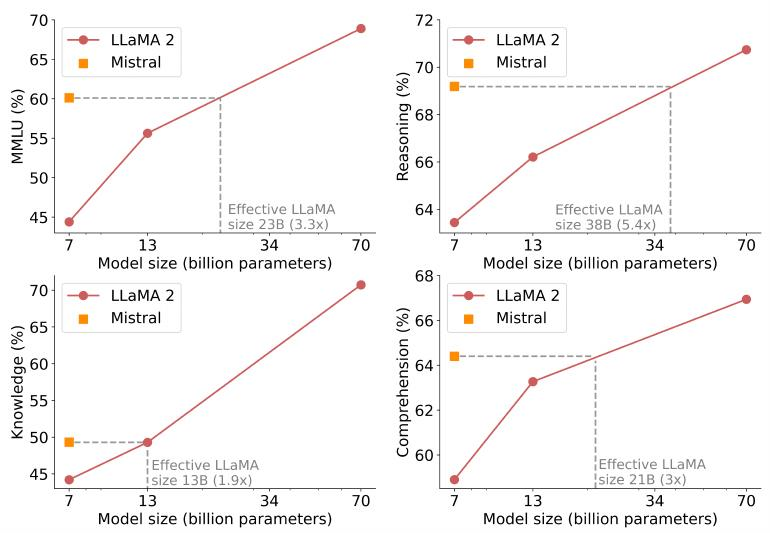

In [24]:
docs = retriever_multi_vector_img.get_relevant_documents(
    "compare and contrast between mistral and llama2 across benchmarks and explain the reasoning in detail", limit=1
)

from PIL import Image


Image.open(io.BytesIO(base64.b64decode(docs[0])))

In [19]:
chain_multimodal_rag.invoke("compare and contrast between mistral and llama2 across benchmarks and explain the reasoning in detail")

' Across all the benchmarks, the performance of both models increase as the model size increases. For the MMU benchmark, both models perform similarly when the model size is 7 billion parameters. However, as the model size increases, the performance of LLaMA2 outperforms Mistral. For the Reasoning benchmark, LLaMA2 outperforms Mistral across all model sizes. For the Knowledge benchmark, Mistral outperforms LLaMA2 when the model size is 7 billion parameters. However, as the model size increases, the performance of LLaMA2 outperforms Mistral. For the Comprehension benchmark, LLaMA2 outperforms Mistral across all model sizes.'